# Collaborative Filtering (CF)

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context.

## Collaborative Filtering, item-item, K-means

In this approach, CF models are developed using **machine learning algorithms** to predict user’s rating of unrated items. 

> We will use **Surprise**
>> Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.



## Read the preprocessed Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
df=pd.read_csv("../../Data/ml-latest-small/PreprocessedData_ml_latest_year_small.csv")
df.head()

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995


## Load Recommender System Class and other important Functions

In [14]:
%run -i utilities.py
%run -i CFKnnMeansModel_Class.py

<Figure size 640x480 with 0 Axes>

## Load Surprise Data from DataFrame, Train-Test Split

In [3]:
from surprise import accuracy
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise.model_selection import train_test_split,cross_validate,RandomizedSearchCV
from surprise import KNNWithMeans
from surprise import KNNBasic
reader = Reader()

df_imp=df.drop(['title','year','genres'],axis=1)

surprise_data = Dataset.load_from_df(df_imp, reader)
trainset, testset = train_test_split(surprise_data, test_size=.25,random_state=10)

In [4]:
def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

## Find Optimal k using RandomizedSearchCV

In [5]:
sim_options = {
    "name": ["cosine", "pearson", "pearson_baseline"],"user_based": [False]
}
params = { 'k': range(2,25,1),'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)

{'rmse': 0.8841290555947501}
{'rmse': {'k': 22, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fcb67824910>}


## Build Model using best parameters

In [6]:
knnwithmeans = clf.best_estimator['rmse']

> Users and items have a raw id and an inner id. Some methods will use/return a raw id (e.g. the predict() method), while some other will use/return an inner id.

> Raw ids are ids as defined in a rating file or in a pandas dataframe. They can be strings or numbers. Note though that if the ratings were read from a file which is the standard scenario, they are represented as strings. This is important to know if you’re using e.g. predict() or other methods that accept raw ids as parameters.

> On trainset creation, each raw id is mapped to a unique integer called inner id, which is a lot more suitable for Surprise to manipulate. Conversions between raw and inner ids can be done using the to_inner_uid(), to_inner_iid(), to_raw_uid(), and to_raw_iid() methods of the trainset.


In [16]:
CF_knnwithmeans = collab_filtering_Kmeans_Model(knnwithmeans,trainset,testset)

### 5. Fit, predict and cross-validate

In [17]:
knnwithmeans_rmse,knnwithmeans_recommenddf =CF_knnwithmeans.fit_and_predict(df,10)

**Fitting the train data...**
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
**Predicting the test data...**
RMSE: 0.8926
**RMSE for the predicted result is 0.893**


In [18]:
knnwithmeans_cv_rmse_cv = CF_knnwithmeans.cross_validate(surprise_data)
mean_cv_RMSE_result = round(knnwithmeans_cv_rmse_cv['test_rmse'].mean(),3)
print('**Mean CV RMSE is ' + str(mean_cv_RMSE_result)  + '**')

**Cross Validating the data...**
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8872  0.8897  0.8810  0.8822  0.8756  0.8831  0.0050  
MAE (testset)     0.6738  0.6765  0.6682  0.6730  0.6648  0.6713  0.0042  
Fit time          18.76   19.10   19.36   19.01   19.02   19.05   0.19    
Test time         8.02 

### Model Errors Plot

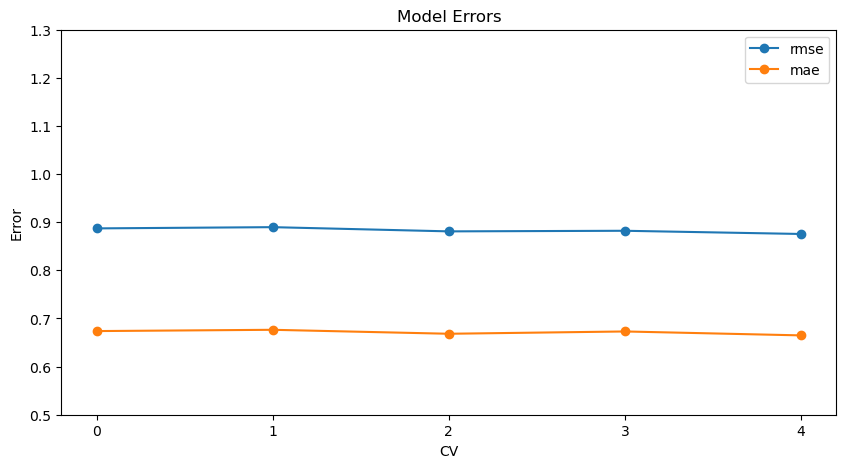

In [19]:
# Get data
rmse = knnwithmeans_cv_rmse_cv['test_rmse']
mae = knnwithmeans_cv_rmse_cv['test_mae']
x = np.arange(len(rmse))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0.5, 1.3)
ax.plot(x, rmse, marker='o', label="rmse")
ax.plot(x, mae, marker='o', label="mae")

# Chart setup
plt.title("Model Errors", fontsize = 12)
plt.xlabel("CV", fontsize = 10)
plt.ylabel("Error", fontsize = 10)
plt.legend()
plt.show()


### 7. Recommend (Item Based)

In [20]:
inp_movie=AskForUserInput(df)

Enter your Favorite Movie: Toy

We have multiple movies with the same name/Part of it, but with different release years:
 movieId                   title  year
       1        Toy Story (1995)  1995
    2253             Toys (1992)  1992
    3114      Toy Story 2 (1999)  1999
    5843     Toy Soldiers (1991)  1991
   78499      Toy Story 3 (2010)  2010
    4929         Toy, The (1982)  1982
    2017 Babes in Toyland (1961)  1961
    3086 Babes in Toyland (1934)  1934
Which one do you have in your mind? (Enter the movieId)1
Your favourite movie: Toy Story (1995)


In [21]:
df_out=CF_knnwithmeans.recommend_similar_items_knnmeans(inp_movie,df, n=10)
print("Because You like the movie",inp_movie,"we'd recommend you to watch:")
display(df_out.head(10))

Because You like the movie Toy Story (1995) we'd recommend you to watch:


,,,,average rating,number of ratings
movieId,title,year,genres,,
364,"Lion King, The (1994)",1994,Adventure|Animation|Children|Drama|Musical|IMAX,3.94,172
588,Aladdin (1992),1992,Adventure|Animation|Children|Comedy|Musical,3.79,183
1073,Willy Wonka & the Chocolate Factory (1971),1971,Children|Comedy|Fantasy|Musical,3.87,119
1097,E.T. the Extra-Terrestrial (1982),1982,Children|Drama|Sci-Fi,3.77,122
1270,Back to the Future (1985),1985,Adventure|Comedy|Sci-Fi,4.04,171
2716,Ghostbusters (a.k.a. Ghost Busters) (1984),1984,Action|Comedy|Sci-Fi,3.78,120
2797,Big (1988),1988,Comedy|Drama|Fantasy|Romance,3.72,91
3114,Toy Story 2 (1999),1999,Adventure|Animation|Children|Comedy|Fantasy,3.86,97
8961,"Incredibles, The (2004)",2004,Action|Adventure|Animation|Children|Comedy,3.84,125


### 7. Save Your Model

In [22]:
import pickle
filename = 'Model_KNN_Means.sav'
pickle.dump(CF_knnwithmeans, open(filename, 'wb'))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity 